In [24]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib as plt
from shapely.geometry import Point

In [27]:
datapath = r'/home/james/Documents/SDG_11.2.1/SDG_11.2.1/data'

In [28]:
stops_df = pd.read_csv(os.path.join(datapath,'Stops.txt'), delimiter='\t')
stops_df.sample(15)


,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type
225827,390010149,sufadmag,"Long Melford, Library (Adjacent)",52.07519,0.71637,NaN,3.0
225237,3890D037901,stoajaga,"Heron Cross, The Locomotive (opp)",52.99379,-2.16116,NaN,3.0
356474,6280000014,64326839,"Newtonloan Toll, Ramsay Cottages (at)",55.85857,-3.07313,NaN,3.0
362468,6400PT1158,36323845,"Fairmuir, Graham Street (at)",56.47751,-2.96979,NaN,3.0
247174,4200F054900,wardgadp,"Rowington, Church (Adj)",52.32219,-1.70428,NaN,3.0
87563,1600GLS885,gloamgaj,"Purton, Riddle Street (NW-bound)",51.72836,-2.44191,NaN,3.0
206754,3600SOB20878,sotawjmt,"Street, Brookside School (opp)",51.11621,-2.74852,NaN,3.0
358792,630041282,23626237,"Stonehaven, Library (E bound)",56.96379,-2.21109,NaN,3.0
7159,021013451,ahladjma,"Dunstable, Turnpike Farm (opp)",51.86588,-0.48856,NaN,3.0
224360,3890D003301,stoadgmj,"Hanley, Ivy House Road (opp)",53.02491,-2.15957,NaN,3.0


In [41]:

def make_geo_df(df,col_x, col_y):
    crs = '27700'
    geometry = [Point(xy) for xy in zip(df[col_x], df[col_y])]
    geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    return geo_df

In [42]:
stops_geo_df = make_geo_df(stops_df,'stop_lat','stop_lon')

In [44]:
stops_geo_df.crs

'27700'

In [45]:
stops_geo_df.sample(10)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry
269470,450012855,45012855,"Cross Gates, Barwick Road Southwood Gate (opp)",53.81524,-1.45102,NaN,3.0,POINT (53.81524 -1.45102)
53373,1100DEC11178,dvndmjgw,"Teignmouth, South Holm (E-bound)",50.54676,-3.52223,NaN,3.0,POINT (50.54676 -3.52223)
190028,3290YYA01660,32901660,"Foss Islands, Morrison's (opp)",53.95963,-1.06984,NaN,3.0,POINT (53.95963 -1.06984)
240857,410000015157,twrdgatd,"Carr Hill, Broadway-Carr Hill Road (S-Bound)",54.94649,-1.58567,NaN,3.0,POINT (54.94649 -1.58567)
290592,490000286Z,91354,"Clapham Common, Nelson's Row (Stop B)",51.46263,-0.13565,NaN,3.0,POINT (51.46263 -0.13565)
325239,5520AWA13772,rhogjpa,"Pontshonnorton, Ysgol Pontsionnorton (os 114)",51.61234,-3.32531,NaN,3.0,POINT (51.61234 -3.32531)
300186,490009907N,75022,"Mill Hill, Mill Hill School (->N)",51.61881,-0.22953,NaN,3.0,POINT (51.61881 -0.22953)
369279,6500K0020,34327327,"Gallatown, Gallatown Roundabout (Southbound)",56.13518,-3.13170,NaN,3.0,POINT (56.13518 -3.13170)
20118,0500HHILT004,CMBDPGAD,"Hilton, Scotts Crescent (near)",52.28020,-0.11176,NaN,3.0,POINT (52.28020 -0.11176)
198672,340001423NOR,oxfgpmaw,"Didcot, Jubilee Way (N-bound)",51.60361,-1.23097,NaN,3.0,POINT (51.60361 -1.23097)


In [46]:
# Building the map of london

map_data_path = '/home/james/Documents/SDG_11.2.1/SDG_11.2.1/data/Statistical-GIS-boundaries-london/statistical-gis-boundaries-london/ESRI'

map_df = gpd.read_file(os.path.join(map_data_path,'London_Borough_Excluding_MHW.shp'))

# OA_2011_London_gen_MHW.shp'

In [47]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [48]:
map_df.crs

{'init': 'epsg:27700'}

In [49]:
map_df.to_crs(epsg=27700)
stops_geo_df.crs = 'epsg:27700'

# epsg:27700


In [50]:
map_df.crs

{'init': 'epsg:27700'}

In [51]:
stops_geo_df.crs

'epsg:27700'

In [52]:
# Wandsworth_034B_df = map_df[map_df['LSOA11NM']=='Wandsworth 034B']

In [53]:
k_u_thames = map_df[map_df['NAME']=='Kingston upon Thames']
k_u_thames.geometry

0    POLYGON ((516401.600 160201.800, 516407.300 16...
Name: geometry, dtype: geometry

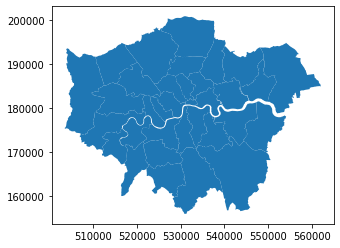

In [54]:
map_df.plot()

In [ ]:
fig, ax = plt.pyplot.subplots()

# _ = Wandsworth_034B_df.plot(ax=ax, facecolor='red')
_ = map_df.plot(ax=ax, facecolor='blue')
_ = k_u_thames.plot(ax=ax, facecolor='red')
_ = stops_geo_df.plot(ax=ax)


In [ ]:
_ = k_u_thames.plot(facecolor='red')

In [ ]:
_ = stops_geo_df.plot()